In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
import numpy as np
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from PIL import Image
from itertools import product
from dataclasses import dataclass
from collections import namedtuple, defaultdict
from markov import *
from base_models import *
from pos_encoder import *
# from attention import *
from config import *
from plot import *
from util import memory_recall_probe, feedforward_probe

We are going to build attention-only TF and the regular TF below, and train them on synthetic markov data.

In [2]:
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.emb_dim = config.emb_dim
        self.n_head = config.num_heads
        self.head_dim = self.emb_dim // self.n_head
        assert self.emb_dim % self.n_head == 0, "Embedding dimension must be divisible by the number of heads."
        if config.identity_query:
            self.query = nn.Identity()
        else:
            self.query = nn.Linear(self.emb_dim, self.emb_dim, bias=config.bias)
        self.key = nn.Linear(self.emb_dim, self.emb_dim, bias=config.bias)
        self.value = nn.Linear(self.emb_dim, self.emb_dim, bias=config.bias)
        if config.freeze_value:
            self.value.weight.requires_grad_(False)
        self.out = nn.Linear(self.emb_dim, self.emb_dim)
        if config.freeze_out:
            self.out.weight.requires_grad_(False)
        self.mask = torch.tril(torch.ones(config.seq_len, config.seq_len)).unsqueeze(0).unsqueeze(1)
        self.mask = self.mask.to(config.device)
        self.get_attn = config.get_attn
        self.pos_enc = config.pos_enc
        self.seq_len = config.seq_len
        self.pos_max_len = config.pos_max_len
        self.scale = self.head_dim ** 0.5
        self.flash = config.flash
        assert not (self.flash and self.pos_enc == "rpe"), "Flash Attention does not support RPE currently."  
        if self.flash:
            self.flashAttend = FlashAttend(config)
        if self.pos_enc == "rpe":
            self.PEK = RelativePositionalEncoding(self.head_dim, self.pos_max_len)
            self.PEV = RelativePositionalEncoding(self.head_dim, self.pos_max_len)
        elif self.pos_enc == "rotary":
            self.rotary_emb = RotaryPositionalEmbeddings(self.head_dim, self.pos_max_len)
        elif self.pos_enc == "alibi":
            self.alibi_emb = AliBiPositionalEncoding(self.n_head)

    def forward(self, x): # (B,T,C)
        batch_size, seq_len, embed_dim = x.size()
        Q = self.query(x).view(batch_size, seq_len, self.n_head, self.head_dim).transpose(1,2) # (B,H,T,D)
        K = self.key(x).view(batch_size, seq_len, self.n_head, self.head_dim).transpose(1,2) # (B,H,T,D)
        V = self.value(x).view(batch_size, seq_len, self.n_head, self.head_dim).transpose(1,2) # (B,H,T,D)
        if self.pos_enc == "rotary":
            Q = self.rotary_emb(Q)
            K = self.rotary_emb(K)
        if self.flash:
            assert self.get_attn == 0, "Flash Attention does not output attentions."
            return self.flashAttend(Q, K, V)
            
        attn_score = Q @ K.transpose(-1,-2) / self.scale
        if self.pos_enc=="rpe":
            # Each B and H, Q_i@(K_j+pe_{i-j}) instead of Q_i@K_j
            # Create a matrix Pos where Pos_{i,j} = pe_{i-j}: \R^D, |i-j| <= max_len <= seq_len
            Q2 = self.query(x).transpose(0,1).view(seq_len,-1,self.head_dim) # (T,B*H,D)
            attn_score2 = torch.matmul(Q2, self.PEK(seq_len).transpose(1,2)) # (T,B*H,D) @ (T,D,T) -> (T,B*H,T)
            attn_score2 = attn_score2.transpose(0,1).contiguous().view(batch_size, -1, seq_len, seq_len) # (B,H,T,T)
            attn_score += attn_score2 / self.scale
        elif self.pos_enc=="alibi":
            attn_score += self.alibi_emb(self.seq_len)
            
        attn_score = attn_score.masked_fill(self.mask==0, -float("inf"))
        attn = F.softmax(attn_score, dim=-1) # (B,H,T,T)
        out = attn @ V # (B,H,T,D)
        if self.pos_enc=="rpe":
            attn2 = attn.view(-1,seq_len,seq_len).transpose(0,1) # (T, B*H, T)
            out2 = torch.matmul(attn2, self.PEV(seq_len)) # (T, B*H, T) @ (T, T, D) -> (T, B*H, D)
            out2 = out2.transpose(0,1).contiguous().view(batch_size, -1, seq_len, self.head_dim) # (B, H, T, D)
            out += out2
        out = out.transpose(1,2).contiguous().view(batch_size,seq_len,-1) # (B, T, C)
        out = self.out(out)
        if self.get_attn > 0:
            return out, attn.detach().cpu() 
        return out
        
        
class TFBlock(nn.Module):
    def __init__(self, config, layer=0):
        super().__init__()
        self.MHA = MultiHeadAttention(config)
        self.ln1 = nn.LayerNorm(config.emb_dim) if config.layer_norm else None
        self.mlp = None
        self.linear_ff = None
        self.dropout = None
        self.get_attn = config.get_attn
        if config.mlp[layer]:
            assert config.ff_dim is not None, "FeedForward dimension cannot be empty."
            if config.activation[layer]:
                self.mlp = nn.Sequential(
                    nn.Linear(config.emb_dim, config.ff_dim),
                    nn.ReLU(),
                    nn.Linear(config.ff_dim, config.emb_dim)
                )
            else:
                self.mlp = nn.Linear(config.emb_dim, config.ff_dim)
            self.ln2 = nn.LayerNorm(config.emb_dim) if config.layer_norm else None
            
        if config.dropout:
            self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        attn_map = None
        if self.get_attn > 0:
            atten_out, attn_map = self.MHA(x)
        else:
            atten_out = self.MHA(x)
        x = x + self.dropout(atten_out) if self.dropout else x + atten_out
        if self.ln1 is not None:
            x = self.ln1(x)
        if self.mlp is not None:
            mlp_out = self.mlp(x)
            if self.dropout is not None:
                x = self.ln2(x + self.dropout(mlp_out)) if self.ln2 else x + self.dropout(mlp_out)
            else:
                x = self.ln2(x + mlp_out) if self.ln2 else x + mlp_out
            
        if self.get_attn > 0:
            return x, attn_map 
        return x
        
class Transformer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embed = nn.Embedding(config.vocab_size, config.emb_dim).to(config.device)
        self.pos_enc = config.pos_enc
        if config.pos_enc == "abs":
            self.positional_encoding = nn.Embedding(config.seq_len, config.emb_dim)
        if len(config.mlp) > 1:
            self.layers = nn.ModuleList([TFBlock(config, layer) for layer in range(config.num_layers)])
        else:
            self.layers = nn.ModuleList([TFBlock(config) for _ in range(config.num_layers)])
            
        self.output_layer = nn.Linear(config.emb_dim, config.vocab_size)
        self.get_attn = config.get_attn
        if self.get_attn > 0:
            self.atten_maps = torch.zeros((config.num_layers, config.num_heads, config.seq_len, config.seq_len))

    def forward(self, x):
        if self.pos_enc == "abs":
            x = self.embed(x) + self.positional_encoding(torch.arange(x.size(1), device=x.device).view(1, x.size(1)))
        else:
            x = self.embed(x)
        for i, layer in enumerate(self.layers):
            if self.get_attn > 0:
                x, attn_map = layer(x)
                self.atten_maps[i] = attn_map.mean(dim=0)
            else:
                x = layer(x)

        logits = self.output_layer(x)
        if self.get_attn > 0: 
            return logits, self.atten_maps 
        return logits

In [2]:
SEQ_LEN = 128
VOC_SIZE = 35
BATCH_SIZE = 128

config = Config(
        emb_dim=128,
        num_heads=1,
        num_layers=1,
        seq_len=SEQ_LEN,
        vocab_size=VOC_SIZE,
        batch_size=BATCH_SIZE,
        test_size=2048,
        num_epochs=1000,
        eval_iter=20,
        pos_enc='abs',
        get_attn=50,
        mlp=(True,),
        activation=(True,),
        flash=True,
        ff_dim=128,
        layer_norm=True,
        max_gram=3,
    )

sampler_config = BBSamplerConfig(seq_len=SEQ_LEN, 
                                 vocab_size=VOC_SIZE, 
                                 batch_size=BATCH_SIZE,
                                 show_mask=True,
                                 k=3)

model = Transformer(config)
model = model.to(config.device)

config.device

'cpu'

### Training

In [3]:
def train(model, config, sampler_config, task_name):
    if task_name == "markov":
        sampler = MarkovSampler(sampler_config)
    elif task_name == "bietti":
        sampler = BiettiTask(sampler_config)
        probes = defaultdict(list)
        probe_keys = ["wk0", "wk1", "wo1"]
    elif task_name == "bb":
        sampler = BBTask(sampler_config)

    flag = task_name in ["bietti", "bb"] 
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
    if config.scheduler is not None:
        scheduler = CosineAnnealingLR(optimizer, T_max=config.T_max)  
    train_losses, eval_losses, eval_steps = [], [], []
    if flag:
        test_data, test_mask = sampler.generate(mode="test")
        bigram_losses, icl_losses = [], []
    else:
        test_data = sampler.generate(mode="test")
    test_y = test_data[:,1:].reshape(-1).to(config.device)
    attn_maps, test_attn_maps = {}, {}

    if config.ngram:
        ngramLearnerDict = {i:ngramLearner(config.vocab_size, i) for i in range(config.max_gram)}
        ngramLosses = defaultdict(list)
    
    for epoch in trange(config.num_epochs):
        model.train()
        if flag:
            batch, out_mask = sampler.generate()
        else:
            batch = sampler.generate() # bottleneck
        optimizer.zero_grad()
        targets = batch[:,1:]
        if config.get_attn > 0 and epoch % config.get_attn == 0:
            outputs, attn = model(batch.to(config.device))
            attn_maps[epoch] = attn.clone()
        else:
            #if config.get_attn > 0:
            outputs, _ = model(batch.to(config.device))
            #else:
            #    outputs = model(batch.to(config.device)) 

        outputs = outputs[:,:-1,:].reshape(-1, config.vocab_size)

        for i, learner in ngramLearnerDict.items():
            ngram_loss = learner.loss(batch)
            ngramLosses[i].append(ngram_loss)
            learner.update(batch)
        
        targets = targets.reshape(-1)
        targets = targets.to(config.device)
        loss = criterion(outputs, targets)

        if flag:
            with torch.no_grad():
                targets_flat = targets.view(-1)
                icl_mask_flat = (out_mask==1)[:,:-1].reshape(-1)
                bigram_loss = criterion(outputs[~icl_mask_flat], 
                                        targets[~icl_mask_flat])
                bigram_losses.append(bigram_loss.item())
                preds = torch.argmax(outputs, dim=-1)
                icl_error = (preds[icl_mask_flat] != targets[icl_mask_flat]).sum()
                total = icl_mask_flat.sum()
                icl_loss = icl_error.float() / total.float()
                icl_losses.append(icl_loss.item())

        train_losses.append(loss.item())
            
        loss.backward()
        optimizer.step()
        if config.scheduler is not None:
            scheduler.step()
        

        if task_name == "bietti":
            for pkey in probe_keys:
                probes[pkey].append(memory_recall_probe(config.vocab_size, model, pkey, config.seq_len, config.device))
            probes['ff'].append(feedforward_probe(config.vocab_size, model, sampler_config.trans_mat, config.device))
    
        if epoch % config.eval_iter == 0:
            with torch.no_grad():
                model.eval()
                if config.get_attn > 0:
                    outputs, test_attn_maps = model(test_data.to(config.device))
                else:
                    outputs, _ = model(test_data.to(config.device))
                outputs = outputs[:,:-1,:].reshape(-1, config.vocab_size)
                loss = criterion(outputs, test_y)
                eval_losses.append(loss.item())
                eval_steps.append(epoch)
                # print(f"Epoch: {epoch}, Evaluation loss: {loss.item()}")
    train_results = {
        "train_losses": train_losses,
        "eval_losses": eval_losses,
        "eval_steps": eval_steps,
        "attn_maps": attn_maps,
        "test_attn_maps": test_attn_maps,
        "sampler": sampler,
    }
    if flag:
        train_results["bigram_losses"] = bigram_losses
        train_results["icl_losses"] = icl_losses
    if task_name == "bietti":
        train_results["probes"] = probes
    if config.ngram:
        train_results["ngramLearners"] = ngramLearnerDict
        train_results["ngramLosses"] = ngramLosses
    return train_results

In [4]:
train_results = train(model, config, sampler_config, 'bb') 

100%|███████████████████████████████████████| 1000/1000 [01:02<00:00, 16.09it/s]


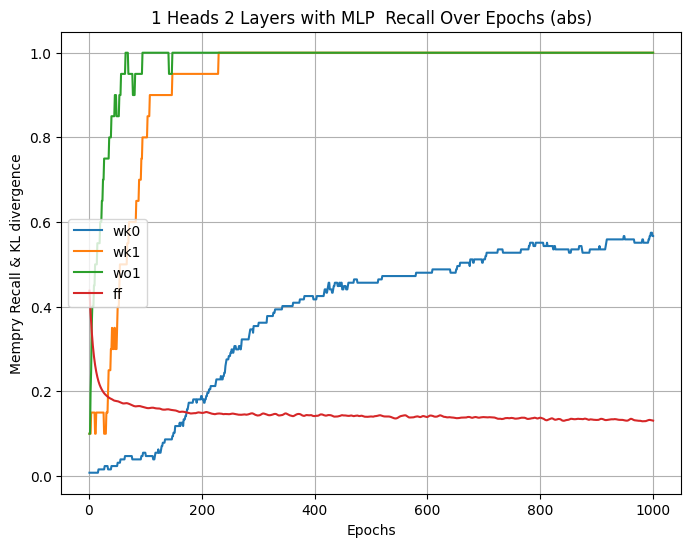

In [13]:
plot_probes(probes, config)

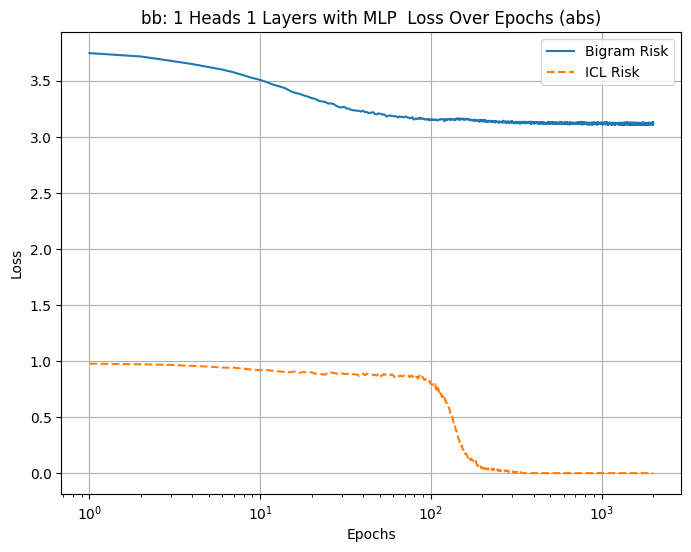

In [34]:
plot_bigram_icl_risk(config, train_results, "bb")

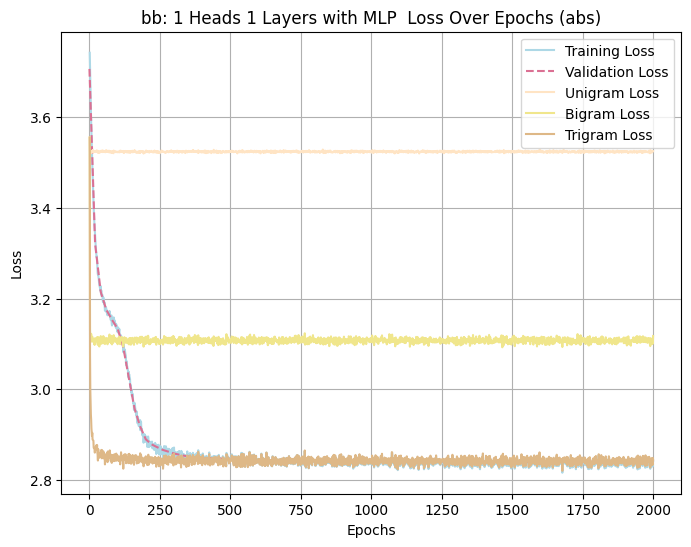

In [35]:
get_loss_plots(config, train_results, 'bb')

In [36]:
get_attn_gif(0,0,train_results,config)

GIF saved at attnmaps_l1h1v35_L0H0.gif
Folder 'attns' and its contents removed.


In [ ]:
train_losses, eval_losses, eval_steps, attn_maps, test_attn_maps = train(model, config)

 37%|███▋      | 74195/200000 [1:04:38<2:04:23, 16.86it/s]

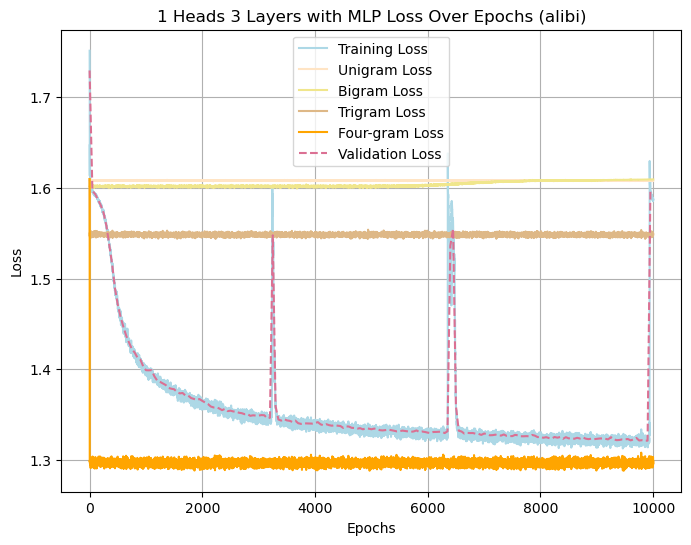

In [12]:
get_loss_plots(config, train_losses, eval_losses, eval_steps, ngramLosses)

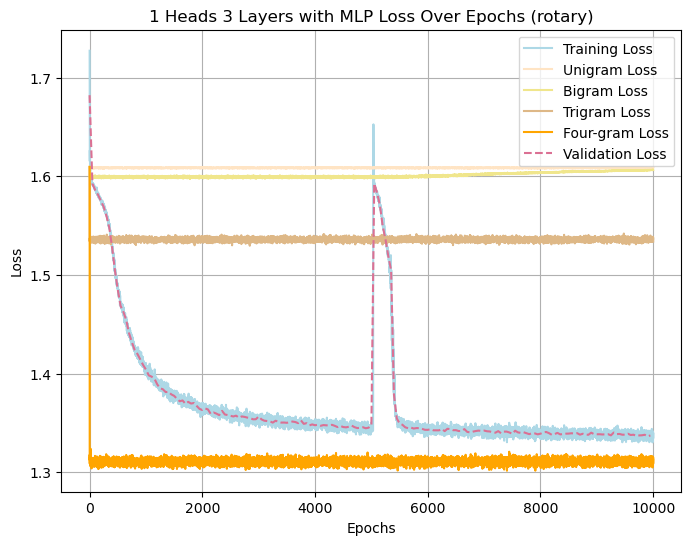

In [16]:
get_loss_plots(config, train_losses, eval_losses, eval_steps, ngramLosses)

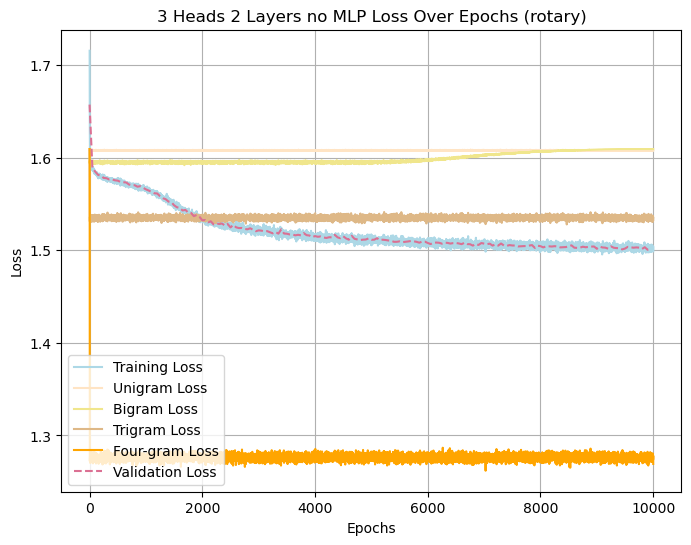

In [6]:
get_loss_plots(config, train_losses, eval_losses, eval_steps, ngramLosses)

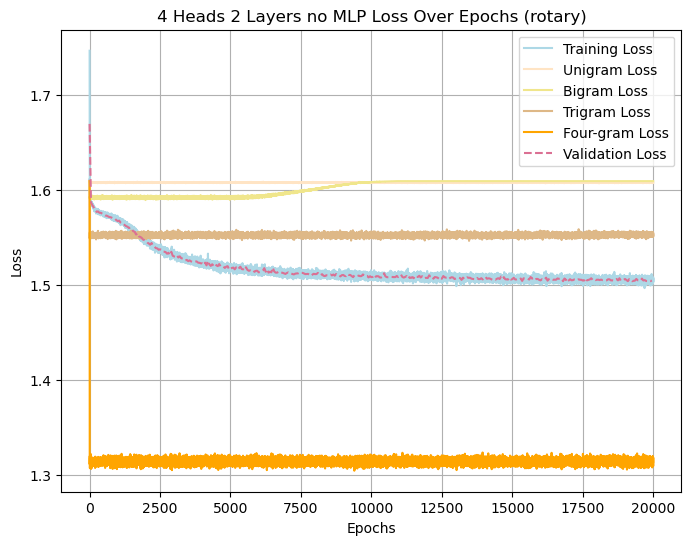

In [9]:
get_loss_plots(config, train_losses, eval_losses, eval_steps, ngramLosses)

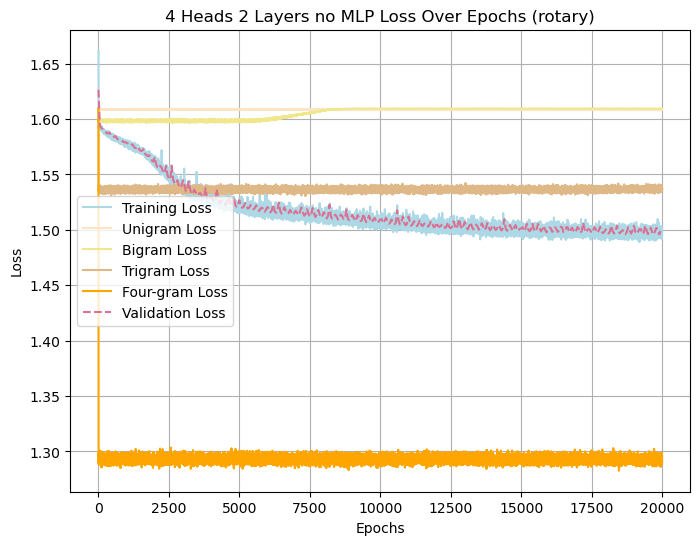

In [7]:
get_loss_plots(config, train_losses, eval_losses, eval_steps, ngramLosses)

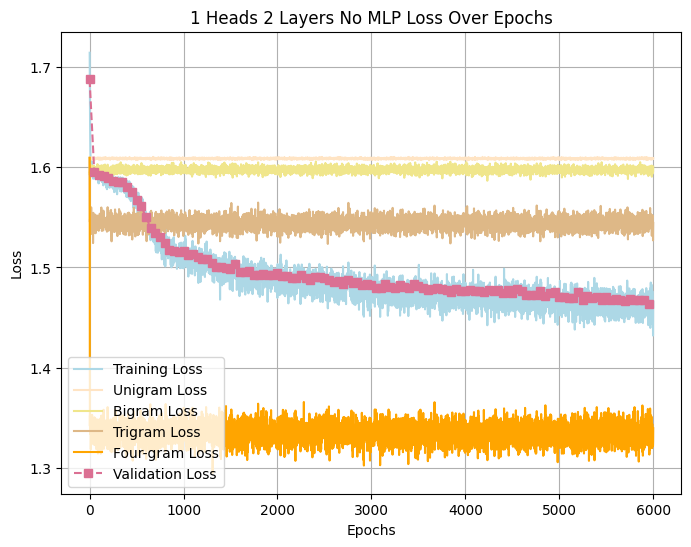

In [233]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, config.num_epochs + 1), train_losses, linestyle='-', color='lightblue', label='Training Loss')
plt.plot(range(1, config.num_epochs + 1), uni_losses, linestyle='-', color='bisque', label='Unigram Loss')
plt.plot(range(1, config.num_epochs + 1), bi_losses, linestyle='-', color='khaki', label='Bigram Loss')
plt.plot(range(1, config.num_epochs + 1), tri_losses, linestyle='-', color='burlywood', label='Trigram Loss')
plt.plot(range(1, config.num_epochs + 1), four_losses, linestyle='-', color='orange', label='Four-gram Loss')
plt.plot(eval_steps, eval_losses, marker='s', linestyle='--', color='palevioletred', label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('1 Heads 2 Layers No MLP Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

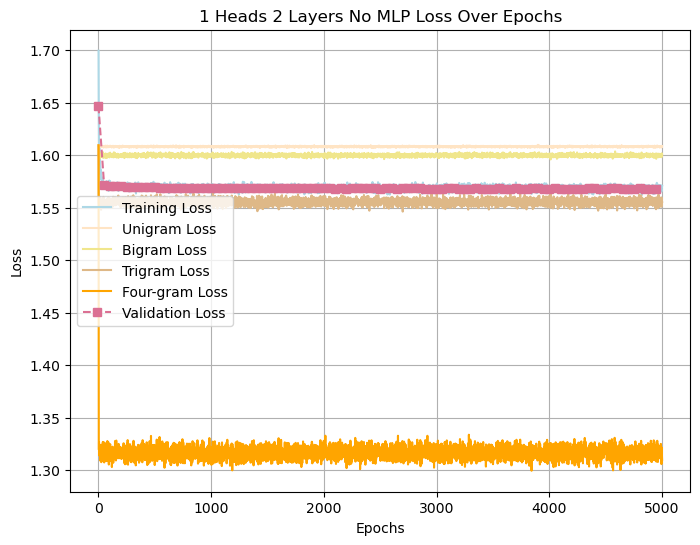

In [808]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, config.num_epochs + 1), train_losses, linestyle='-', color='lightblue', label='Training Loss')
plt.plot(range(1, config.num_epochs + 1), ngramLosses[0], linestyle='-', color='bisque', label='Unigram Loss')
plt.plot(range(1, config.num_epochs + 1), ngramLosses[1], linestyle='-', color='khaki', label='Bigram Loss')
plt.plot(range(1, config.num_epochs + 1), ngramLosses[2], linestyle='-', color='burlywood', label='Trigram Loss')
plt.plot(range(1, config.num_epochs + 1), ngramLosses[3], linestyle='-', color='orange', label='Four-gram Loss')
plt.plot(eval_steps, eval_losses, marker='s', linestyle='--', color='palevioletred', label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('1 Heads 2 Layers No MLP Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

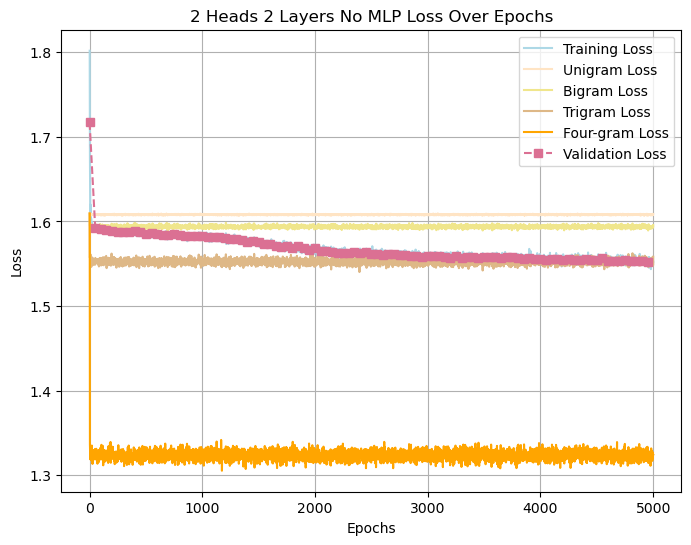

In [814]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, config.num_epochs + 1), train_losses, linestyle='-', color='lightblue', label='Training Loss')
plt.plot(range(1, config.num_epochs + 1), ngramLosses[0], linestyle='-', color='bisque', label='Unigram Loss')
plt.plot(range(1, config.num_epochs + 1), ngramLosses[1], linestyle='-', color='khaki', label='Bigram Loss')
plt.plot(range(1, config.num_epochs + 1), ngramLosses[2], linestyle='-', color='burlywood', label='Trigram Loss')
plt.plot(range(1, config.num_epochs + 1), ngramLosses[3], linestyle='-', color='orange', label='Four-gram Loss')
plt.plot(eval_steps, eval_losses, marker='s', linestyle='--', color='palevioletred', label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('2 Heads 2 Layers No MLP Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

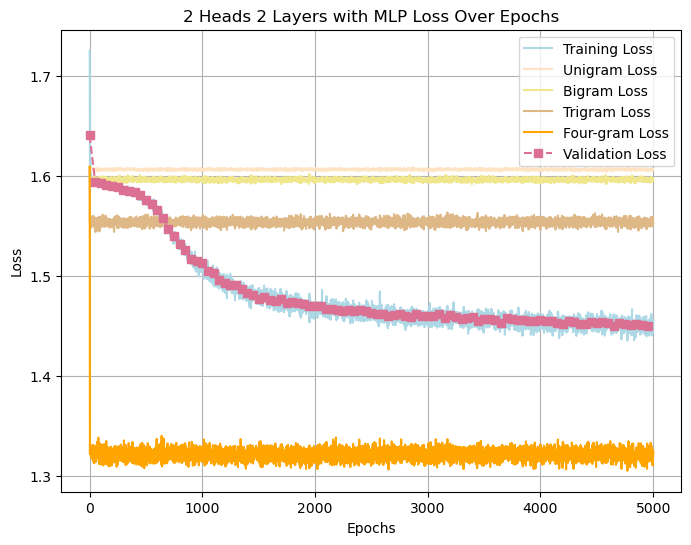

In [828]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, config.num_epochs + 1), train_losses, linestyle='-', color='lightblue', label='Training Loss')
plt.plot(range(1, config.num_epochs + 1), ngramLosses[0], linestyle='-', color='bisque', label='Unigram Loss')
plt.plot(range(1, config.num_epochs + 1), ngramLosses[1], linestyle='-', color='khaki', label='Bigram Loss')
plt.plot(range(1, config.num_epochs + 1), ngramLosses[2], linestyle='-', color='burlywood', label='Trigram Loss')
plt.plot(range(1, config.num_epochs + 1), ngramLosses[3], linestyle='-', color='orange', label='Four-gram Loss')
plt.plot(eval_steps, eval_losses, marker='s', linestyle='--', color='palevioletred', label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('2 Heads 2 Layers with MLP Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

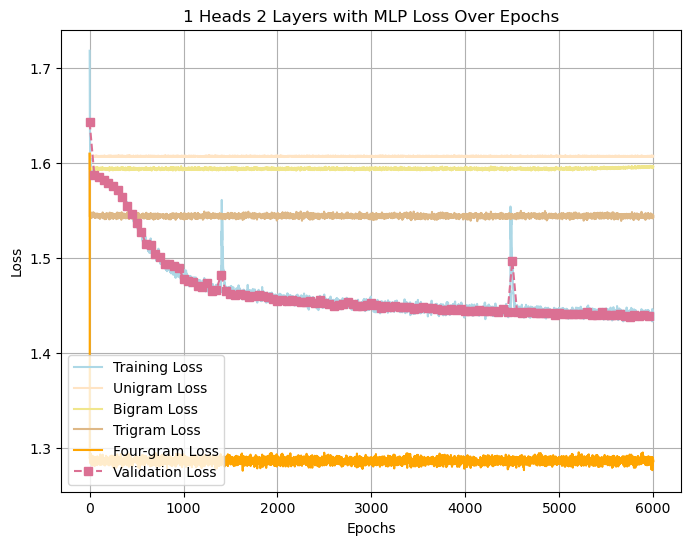

In [832]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, config.num_epochs + 1), train_losses, linestyle='-', color='lightblue', label='Training Loss')
plt.plot(range(1, config.num_epochs + 1), ngramLosses[0], linestyle='-', color='bisque', label='Unigram Loss')
plt.plot(range(1, config.num_epochs + 1), ngramLosses[1], linestyle='-', color='khaki', label='Bigram Loss')
plt.plot(range(1, config.num_epochs + 1), ngramLosses[2], linestyle='-', color='burlywood', label='Trigram Loss')
plt.plot(range(1, config.num_epochs + 1), ngramLosses[3], linestyle='-', color='orange', label='Four-gram Loss')
plt.plot(eval_steps, eval_losses, marker='s', linestyle='--', color='palevioletred', label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('1 Heads 2 Layers with MLP Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

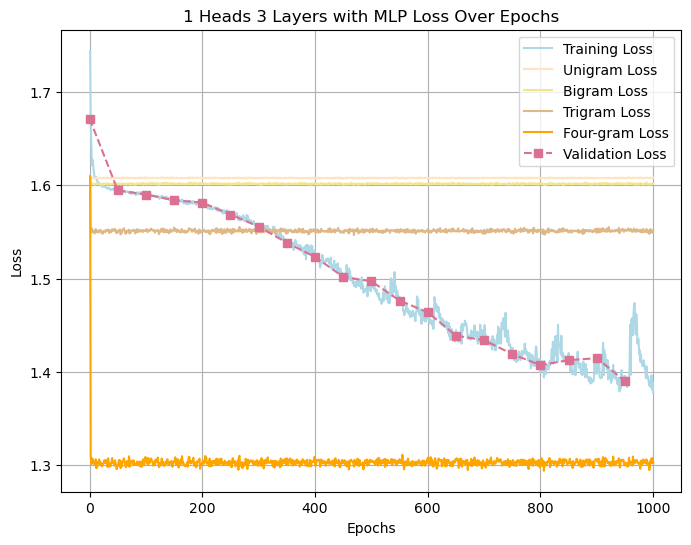

In [9]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, config.num_epochs + 1), train_losses, linestyle='-', color='lightblue', label='Training Loss')
plt.plot(range(1, config.num_epochs + 1), ngramLosses[0], linestyle='-', color='bisque', label='Unigram Loss')
plt.plot(range(1, config.num_epochs + 1), ngramLosses[1], linestyle='-', color='khaki', label='Bigram Loss')
plt.plot(range(1, config.num_epochs + 1), ngramLosses[2], linestyle='-', color='burlywood', label='Trigram Loss')
plt.plot(range(1, config.num_epochs + 1), ngramLosses[3], linestyle='-', color='orange', label='Four-gram Loss')
plt.plot(eval_steps, eval_losses, marker='s', linestyle='--', color='palevioletred', label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('1 Heads 3 Layers with MLP Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

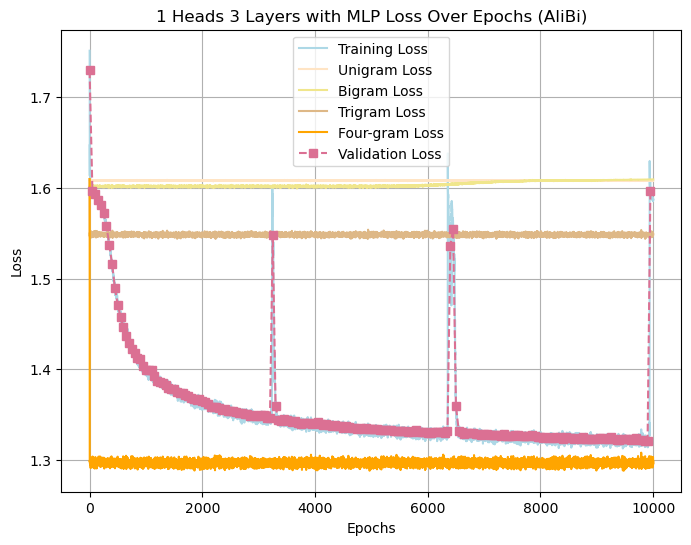

In [8]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, config.num_epochs + 1), train_losses, linestyle='-', color='lightblue', label='Training Loss')
plt.plot(range(1, config.num_epochs + 1), ngramLosses[0], linestyle='-', color='bisque', label='Unigram Loss')
plt.plot(range(1, config.num_epochs + 1), ngramLosses[1], linestyle='-', color='khaki', label='Bigram Loss')
plt.plot(range(1, config.num_epochs + 1), ngramLosses[2], linestyle='-', color='burlywood', label='Trigram Loss')
plt.plot(range(1, config.num_epochs + 1), ngramLosses[3], linestyle='-', color='orange', label='Four-gram Loss')
plt.plot(eval_steps, eval_losses, marker='s', linestyle='--', color='palevioletred', label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('1 Heads 3 Layers with MLP Loss Over Epochs (AliBi)')
plt.legend()
plt.grid()
plt.show()